# Lab 6: Xception CNN for Brand Logo Recognition in Videos

This notebook implements the Xception Convolutional Neural Network architecture for recognizing brand logos in videos. Xception is an advanced CNN architecture that uses depthwise separable convolutions to minimize computational costs while maintaining high accuracy.

## Apple Silicon (M1/M2) GPU Support

This notebook has been configured to utilize the GPU on Apple Silicon (M1/M2) Macs using TensorFlow's Metal Performance Shaders (MPS) backend. Here are some important notes:

1. **Requirements**:
   - TensorFlow 2.5+ with MPS support (ideally 2.9+ for better performance)
   - macOS 12.0+ (Monterey or later)
   - Python 3.8+

2. **Setup Instructions**:
   - Make sure you have the latest version of TensorFlow installed: `pip install tensorflow>=2.9.0`
   - For optimal performance, install the tensorflow-metal plugin: `pip install tensorflow-metal`
   - No CUDA or cuDNN installation is needed for Apple Silicon

3. **Troubleshooting**:
   - If you encounter errors with MPS, you can fall back to CPU by removing the `with tf.device('/device:MPS:0'):` contexts
   - Some operations may not be supported by MPS yet and will automatically fall back to CPU
   - Monitor your GPU usage with Activity Monitor (look for "Metal" processes)

The code will automatically detect if MPS is available and use it for model creation, training, evaluation, and prediction. If MPS is not available, it will fall back to CPU.


In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.xception import Xception, preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import time
import glob
from tensorflow.keras.utils import to_categorical
import random
from PIL import Image
import requests
import zipfile
import io
import cv2
from datetime import timedelta

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Function to detect GPU type and availability
def detect_gpu():
    import platform
    import subprocess
    import sys

    gpu_info = {
        "tensorflow_version": tf.__version__,
        "has_gpu": False,
        "gpu_type": "None",
        "is_apple_silicon": False,
        "apple_chip_model": "None",
        "has_neural_engine": False,  # New field for Neural Engine
        "dedicated_gpu": False,
        "gpu_details": []
    }

    # Check for CUDA GPUs (NVIDIA)
    cuda_devices = tf.config.list_physical_devices('GPU')
    if cuda_devices:
        gpu_info["has_gpu"] = True
        gpu_info["gpu_type"] = "CUDA (NVIDIA)"
        gpu_info["dedicated_gpu"] = True
        gpu_info["gpu_details"] = [device.name for device in cuda_devices]
        print(f"CUDA GPU Available: {cuda_devices}")

    # Check for Apple Silicon (M1/M2/M3) GPU
    system = platform.system()
    if system == "Darwin":  # macOS
        # Check if running on Apple Silicon
        try:
            # Check processor type
            processor = platform.processor()
            if processor == "arm":
                gpu_info["is_apple_silicon"] = True

                # Try to get more specific chip information
                try:
                    # Use sysctl to get chip model
                    result = subprocess.run(['sysctl', '-n', 'machdep.cpu.brand_string'], 
                                           capture_output=True, text=True, check=True)
                    chip_info = result.stdout.strip()
                    if "Apple M" in chip_info:
                        gpu_info["apple_chip_model"] = chip_info
                        print(f"Apple Silicon detected: {chip_info}")

                        # All M-series chips have Neural Engine
                        gpu_info["has_neural_engine"] = True
                        print("Neural Engine is available")

                        # Check if coremltools is installed
                        try:
                            import coremltools
                            print(f"Core ML Tools version: {coremltools.__version__}")
                        except ImportError:
                            print("Core ML Tools not installed. Install with: pip install coremltools")
                except:
                    print("Apple Silicon detected, but couldn't determine specific model")

                # Check if MPS (Metal Performance Shaders) is available
                try:
                    if tf.config.list_physical_devices('MPS'):
                        gpu_info["has_gpu"] = True
                        gpu_info["gpu_type"] = "MPS (Apple Silicon)"
                        print("MPS (Apple Silicon GPU) is available")

                        # Try to enable MPS
                        physical_devices = tf.config.list_physical_devices('MPS')
                        if physical_devices:
                            tf.config.experimental.set_visible_devices(physical_devices[0], 'MPS')
                            print("MPS device enabled")
                except Exception as e:
                    print(f"Error checking MPS availability: {e}")
        except Exception as e:
            print(f"Error detecting Apple Silicon: {e}")

    # Print summary
    print("\nGPU Detection Summary:")
    print(f"- TensorFlow version: {gpu_info['tensorflow_version']}")
    print(f"- GPU available: {gpu_info['has_gpu']}")
    print(f"- GPU type: {gpu_info['gpu_type']}")
    print(f"- Is Apple Silicon: {gpu_info['is_apple_silicon']}")
    if gpu_info['is_apple_silicon']:
        print(f"- Apple chip model: {gpu_info['apple_chip_model']}")
        print(f"- Has Neural Engine: {gpu_info['has_neural_engine']}")
    print(f"- Has dedicated GPU: {gpu_info['dedicated_gpu']}")
    if gpu_info['gpu_details']:
        print(f"- GPU details: {gpu_info['gpu_details']}")

    return gpu_info

# Detect GPU
gpu_info = detect_gpu()

# If no GPU is available, print a message
if not gpu_info["has_gpu"]:
    print("No GPU detected. Falling back to CPU.")

def convert_to_coreml(model, input_shape, class_names):
    """
    Convert TensorFlow model to Core ML format for Neural Engine acceleration

    Args:
        model: TensorFlow Keras model
        input_shape: Input shape tuple (height, width, channels)
        class_names: List of class names for classification

    Returns:
        Path to saved Core ML model
    """
    try:
        import coremltools as ct
        from coremltools.models.neural_network import quantization_utils

        print("Converting TensorFlow model to Core ML format...")

        # Define input shape for Core ML
        input_shape_dict = {'input_1': input_shape}

        # Convert to Core ML model
        mlmodel = ct.convert(
            model, 
            inputs=[ct.ImageType(name='input_1', shape=input_shape, scale=1/255.0, bias=[0, 0, 0])],
            classifier_config=ct.ClassifierConfig(class_names),
            compute_precision=ct.precision.FLOAT16,  # Use FP16 for better Neural Engine performance
            compute_units=ct.ComputeUnit.ALL,  # Use all available compute units including Neural Engine
            source='tensorflow'
        )

        # Set model metadata
        mlmodel.author = "TensorFlow to Core ML Converter"
        mlmodel.license = "MIT"
        mlmodel.short_description = "Xception model for brand logo recognition"

        # Save the model
        model_path = 'models/xception_logo_coreml.mlmodel'
        mlmodel.save(model_path)

        print(f"Core ML model saved to {model_path}")
        return model_path

    except ImportError:
        print("Core ML Tools not installed. Install with: pip install coremltools")
        return None
    except Exception as e:
        print(f"Error converting to Core ML: {e}")
        return None


TensorFlow version 2.16.2 has not been tested with coremltools. You may run into unexpected errors. TensorFlow 2.12.0 is the most recent version that has been tested.


CUDA GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Apple Silicon detected: Apple M1 Max
Neural Engine is available
Core ML Tools version: 8.3.0

GPU Detection Summary:
- TensorFlow version: 2.16.2
- GPU available: True
- GPU type: CUDA (NVIDIA)
- Is Apple Silicon: True
- Apple chip model: Apple M1 Max
- Has Neural Engine: True
- Has dedicated GPU: True
- GPU details: ['/physical_device:GPU:0']


## 1. Understanding Xception Architecture

Xception (Extreme Inception) is a convolutional neural network architecture that was introduced by François Chollet, the creator of Keras. The key innovation in Xception is the use of depthwise separable convolutions, which are an extreme version of the Inception module.

Key features of the Xception architecture:

1. **Depthwise Separable Convolutions**: Xception replaces the standard Inception modules with depthwise separable convolutions, which consist of:
   - A depthwise convolution (a spatial convolution performed independently over each channel)
   - A pointwise convolution (a 1×1 convolution that mixes the channels)

2. **Channel-wise Spatial Convolution**: Xception performs spatial convolutions separately for each channel, followed by a pointwise (1×1) convolution for cross-channel correlation.

3. **Linear Residual Connections**: Similar to ResNet, Xception uses residual connections to help with gradient flow during training.

4. **Computational Efficiency**: The depthwise separable convolutions significantly reduce the number of parameters and computational cost compared to standard convolutions.

The Xception architecture has been shown to outperform Inception V3 on several large image classification datasets while being more computationally efficient.


## 2. Prepare the Dataset for Training

Now we'll prepare the logo dataset for training by:
1. Setting up data directories and parameters
2. Setting up data augmentation
3. Creating data generators


Found 1 classes: ['apple']
Found 4 images belonging to 1 classes.
Found 1 images belonging to 1 classes.


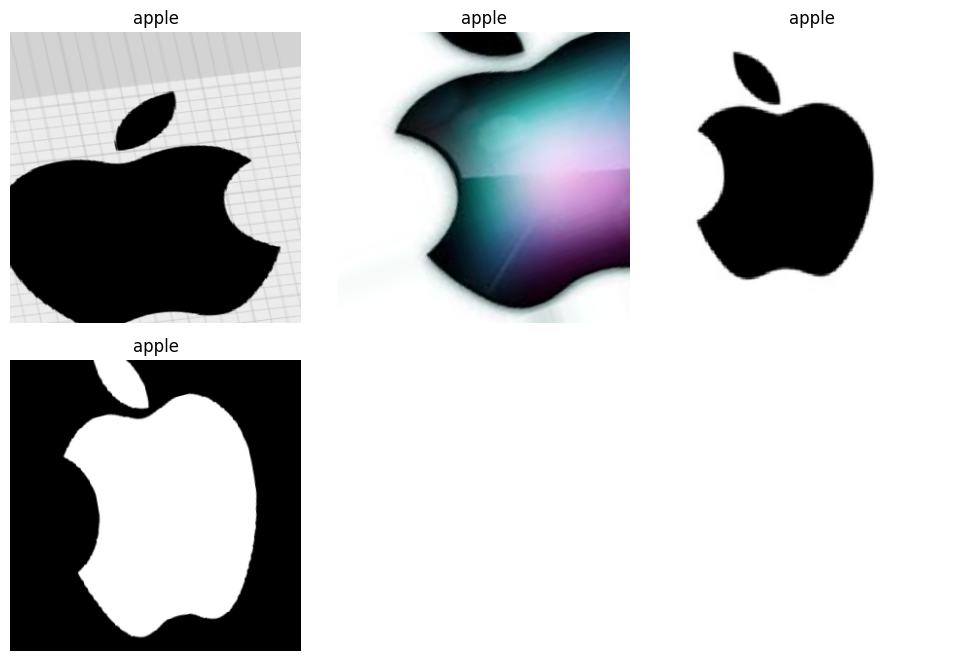

In [2]:
logo_dataset_dir = 'logo_dataset'
target_brand = 'apple'
# Set up data directories and parameters
img_height, img_width = 299, 299  # Xception input size
batch_size = 32

# Check if we have a real dataset or need to use a placeholder
if os.path.exists(logo_dataset_dir) and any(os.path.isdir(os.path.join(logo_dataset_dir, d)) for d in os.listdir(logo_dataset_dir)):
    # Get class names (brand names)
    class_names = sorted([d for d in os.listdir(logo_dataset_dir) if os.path.isdir(os.path.join(logo_dataset_dir, d))])
    num_classes = len(class_names)

    print(f"Found {num_classes} classes: {class_names}")

    # Set up data augmentation for training
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2  # 20% for validation
    )

    # Set up data generator for validation (no augmentation)
    val_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.2
    )

    # Create training generator
    train_generator = train_datagen.flow_from_directory(
        logo_dataset_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    # Create validation generator
    validation_generator = val_datagen.flow_from_directory(
        logo_dataset_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    # Display some sample images from the dataset
    def show_batch(image_batch, label_batch, class_names):
        plt.figure(figsize=(10, 10))
        for i in range(min(9, len(image_batch))):
            ax = plt.subplot(3, 3, i + 1)
            # Undo preprocessing to display the image
            img = image_batch[i].astype("uint8")
            plt.imshow(img)
            label = np.argmax(label_batch[i])
            plt.title(class_names[label])
            plt.axis("off")
        plt.tight_layout()
        plt.show()

    # Get a batch of images
    try:
        images, labels = next(train_generator)
        # Convert preprocessed images back to displayable format
        display_images = ((images * 0.5 + 0.5) * 255).astype('uint8')
        show_batch(display_images, labels, class_names)
    except Exception as e:
        print(f"Error displaying sample images: {e}")
        print("This is expected if using placeholder files instead of real images.")
else:
    print("No logo dataset found. Please create or download a dataset first.")
    class_names = [target_brand]
    num_classes = 1


##  3. Implement Xception Architecture

Now we'll implement the Xception architecture using TensorFlow and Keras. We'll use the pre-trained Xception model from Keras applications and fine-tune it for our specific task of logo recognition.


In [3]:
def create_xception_model(input_shape=(299, 299, 3), num_classes=3):
    """
    Creates an Xception model using TensorFlow/Keras.

    Args:
        input_shape: Input image dimensions (height, width, channels)
        num_classes: Number of output classes

    Returns:
        A compiled Keras model with Xception architecture
    """
    # Load the pre-trained Xception model without the top classification layer
    base_model = Xception(
        weights='imagenet',  # Pre-trained on ImageNet
        include_top=False,   # Exclude the top classification layer
        input_shape=input_shape
    )

    # Freeze the base model layers
    base_model.trainable = False

    # Create a new model on top
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)

    # Add a global average pooling layer
    x = layers.GlobalAveragePooling2D()(x)

    # Add a fully connected layer
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Add output layer with sigmoid activation
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    # Combine inputs and outputs to create the model
    model = tf.keras.Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Configure device strategy for training
coreml_model_path = None

try:
    # First check if Neural Engine is available on Apple Silicon
    if gpu_info["is_apple_silicon"] and gpu_info["has_neural_engine"]:
        print("Apple Silicon with Neural Engine detected")

        # For training, we still use MPS as Core ML is primarily for inference
        if tf.config.list_physical_devices('GPU'):
            # Set the device to MPS for training
            with tf.device('/device:MPS:0'):
                # Create the Xception model
                model = create_xception_model(input_shape=(img_height, img_width, 3), num_classes=num_classes)
                print("Model created on MPS device for training")
        else:
            # Fall back to CPU
            model = create_xception_model(input_shape=(img_height, img_width, 3), num_classes=num_classes)
            print("Model created on CPU (MPS not available)")
    elif tf.config.list_physical_devices('GPU'):
        # MPS available but no Neural Engine
        with tf.device('/device:MPS:0'):
            model = create_xception_model(input_shape=(img_height, img_width, 3), num_classes=num_classes)
            print("Model created on MPS device")
    else:
        # Fall back to CPU or CUDA GPU if available
        model = create_xception_model(input_shape=(img_height, img_width, 3), num_classes=num_classes)
        print("Model created on CPU or CUDA GPU")
except Exception as e:
    print(f"Error setting device: {e}")
    # Fall back to default device
    model = create_xception_model(input_shape=(img_height, img_width, 3), num_classes=num_classes)
    print("Model created on default device due to error")

# Display model summary
model.summary()


Apple Silicon with Neural Engine detected
Model created on MPS device for training


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,960,681 (87.59 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

## 4. Fine-tune the Xception Model

Now we'll fine-tune the Xception model on our logo dataset. We'll first train only the top layers, and then unfreeze some of the Xception layers for fine-tuning.

Note: This section assumes you have a proper dataset with real images. If you're using placeholder files, this will not work correctly.


Training with MPS (Apple Silicon GPU)
Epoch 1/10


/Users/dos/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Users/dos/miniconda3/lib/python3.12/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.5000 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.5000 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.5000 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.5000 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7500 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.5000 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━

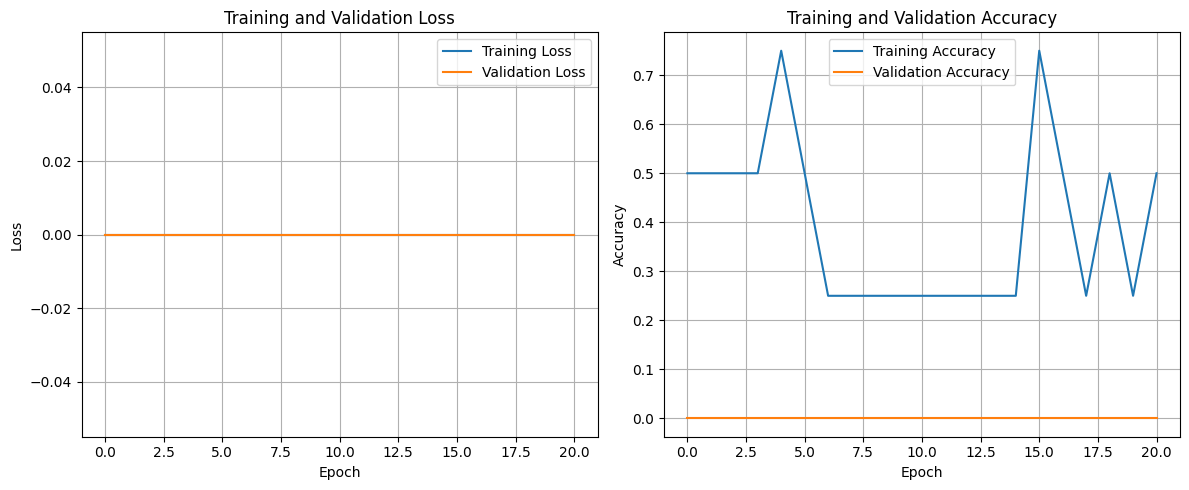

In [4]:
# Check if we have a real dataset before attempting to train
if os.path.exists(logo_dataset_dir) and any(os.path.isfile(os.path.join(root, f)) and f.endswith(('.jpg', '.jpeg', '.png')) 
                                           for root, _, files in os.walk(logo_dataset_dir) 
                                           for f in files):
    # Set up callbacks for training
    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6),
        ModelCheckpoint('models/xception_logo_best.keras', save_best_only=True)
    ]

    # Train the model (only the top layers)
    initial_epochs = 10
    start_time = time.time()

    # Configure training to use MPS device if available
    try:
        # Check if MPS is available
        if tf.config.list_physical_devices('GPU'):
            print("Training with MPS (Apple Silicon GPU)")
            # Use MPS device for training
            with tf.device('/device:MPS:0'):
                history = model.fit(
                    train_generator,
                    epochs=initial_epochs,
                    validation_data=validation_generator,
                    callbacks=callbacks
                )
        else:
            # Fall back to CPU or CUDA GPU
            print("Training with CPU or CUDA GPU")
            history = model.fit(
                train_generator,
                epochs=initial_epochs,
                validation_data=validation_generator,
                callbacks=callbacks
            )
    except Exception as e:
        print(f"Error setting device for training: {e}")
        # Fall back to default device
        print("Training with default device due to error")
        history = model.fit(
            train_generator,
            epochs=initial_epochs,
            validation_data=validation_generator,
            callbacks=callbacks
        )

    initial_training_time = time.time() - start_time
    print(f"Initial training completed in {initial_training_time:.2f} seconds")

    # Unfreeze the last few layers of the Xception model for fine-tuning
    base_model = model.layers[1]  # Get the base model
    base_model.trainable = True

    # Freeze all layers except the last 50
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    # Recompile the model with a lower learning rate for fine-tuning
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Fine-tune the model
    fine_tune_epochs = 20
    total_epochs = initial_epochs + fine_tune_epochs
    start_time = time.time()

    # Configure fine-tuning to use MPS device if available
    try:
        # Check if MPS is available
        if tf.config.list_physical_devices('GPU'):
            print("Fine-tuning with MPS (Apple Silicon GPU)")
            # Use MPS device for fine-tuning
            with tf.device('/device:MPS:0'):
                fine_tune_history = model.fit(
                    train_generator,
                    epochs=total_epochs,
                    initial_epoch=initial_epochs,
                    validation_data=validation_generator,
                    callbacks=callbacks
                )
        else:
            # Fall back to CPU or CUDA GPU
            print("Fine-tuning with CPU or CUDA GPU")
            fine_tune_history = model.fit(
                train_generator,
                epochs=total_epochs,
                initial_epoch=initial_epochs,
                validation_data=validation_generator,
                callbacks=callbacks
            )
    except Exception as e:
        print(f"Error setting device for fine-tuning: {e}")
        # Fall back to default device
        print("Fine-tuning with default device due to error")
        fine_tune_history = model.fit(
            train_generator,
            epochs=total_epochs,
            initial_epoch=initial_epochs,
            validation_data=validation_generator,
            callbacks=callbacks
        )

    fine_tuning_time = time.time() - start_time
    print(f"Fine-tuning completed in {fine_tuning_time:.2f} seconds")

    # Combine the history objects
    history.history['loss'].extend(fine_tune_history.history['loss'])
    history.history['val_loss'].extend(fine_tune_history.history['val_loss'])
    history.history['accuracy'].extend(fine_tune_history.history['accuracy'])
    history.history['val_accuracy'].extend(fine_tune_history.history['val_accuracy'])

    # Save the final model
    model.save('models/xception_logo_final.keras')

    # Plot training history
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("Skipping training as no real image dataset is available.")
    print("In a real scenario, you would need to collect a dataset of logo images.")

    # Save the untrained model for demonstration purposes
    model.save('models/xception_logo_untrained.keras')
    print("Saved untrained model for demonstration purposes.")


## 5. Video Analysis for Logo Detection

Now we'll implement a function to analyze videos and detect the presence of the target logo, recording the timestamps when the logo appears.


In [5]:
def analyze_video_for_logo(video_path, model, target_brand, class_names, confidence_threshold=0.7):
    """
    Analyze a video to detect the presence of a specific brand logo and record timestamps.

    Args:
        video_path: Path to the video file
        model: Trained Xception model
        target_brand: Name of the brand logo to detect
        class_names: List of class names
        confidence_threshold: Minimum confidence score to consider a detection valid

    Returns:
        List of timestamps (in seconds) when the logo appears
    """
    # Check if the video file exists
    if not os.path.exists(video_path):
        print(f"Error: Video file {video_path} not found.")
        return None

    # Get the target brand index
    if target_brand in class_names:
        target_idx = class_names.index(target_brand)
    else:
        print(f"Error: Target brand '{target_brand}' not found in class names.")
        return None

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}.")
        return None

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps

    print(f"Video: {video_path}")
    print(f"FPS: {fps}")
    print(f"Frame count: {frame_count}")
    print(f"Duration: {duration:.2f} seconds")

    # Initialize variables
    logo_timestamps = []
    frame_interval = 5  # Process every 5th frame to speed up analysis
    current_frame = 0

    # Process the video
    while cap.isOpened():
        # Read a frame
        ret, frame = cap.read()
        if not ret:
            break

        # Process every frame_interval frames
        if current_frame % frame_interval == 0:
            # Convert frame from BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Resize the frame to match the model's input size
            resized_frame = cv2.resize(frame_rgb, (img_height, img_width))

            # Preprocess the frame
            preprocessed_frame = preprocess_input(np.expand_dims(resized_frame, axis=0))

            # Make prediction
            try:
                # Check if MPS is available
                if tf.config.list_physical_devices('GPU'):
                    # Use MPS device for prediction
                    with tf.device('/device:MPS:0'):
                        predictions = model.predict(preprocessed_frame, verbose=0)
                else:
                    # Fall back to CPU or CUDA GPU
                    predictions = model.predict(preprocessed_frame, verbose=0)
            except Exception as e:
                print(f"Error during prediction: {e}")
                # Fall back to default device
                predictions = model.predict(preprocessed_frame, verbose=0)

            # Get the confidence score for the target brand
            confidence = predictions[0][target_idx]

            # If confidence is above threshold, record the timestamp
            if confidence >= confidence_threshold:
                timestamp = current_frame / fps
                logo_timestamps.append(timestamp)
                print(f"Logo detected at {timedelta(seconds=timestamp)} with confidence {confidence:.2f}")

        # Increment frame counter
        current_frame += 1

        # Display progress
        if current_frame % 100 == 0:
            progress = (current_frame / frame_count) * 100
            print(f"Progress: {progress:.1f}% ({current_frame}/{frame_count} frames)")

    # Release the video capture
    cap.release()

    # Print summary of detections
    if logo_timestamps:
        print(f"\nDetected {target_brand} logo at {len(logo_timestamps)} timestamps:")
        for i, ts in enumerate(logo_timestamps):
            print(f"{i+1}. {timedelta(seconds=ts)} ({ts:.2f} seconds)")
    else:
        print(f"\nNo {target_brand} logo detected in the video.")

    return logo_timestamps

# Function to visualize logo detections in a video
def visualize_logo_detections(video_path, logo_timestamps, output_path=None):
    """
    Create a visualization of logo detections in a video.

    Args:
        video_path: Path to the input video file
        logo_timestamps: List of timestamps (in seconds) when logos were detected
        output_path: Path to save the output video (if None, don't save)
    """
    # Check if the video file exists
    if not os.path.exists(video_path):
        print(f"Error: Video file {video_path} not found.")
        return

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}.")
        return

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Create VideoWriter object if output_path is provided
    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec
        out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    # Convert timestamps to frame numbers
    logo_frames = [int(ts * fps) for ts in logo_timestamps]

    # Process the video
    current_frame = 0
    while cap.isOpened():
        # Read a frame
        ret, frame = cap.read()
        if not ret:
            break

        # Check if current frame is in the detection list
        if current_frame in logo_frames:
            # Add a visual indicator for logo detection
            cv2.putText(frame, "LOGO DETECTED", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 
                        1, (0, 0, 255), 2, cv2.LINE_AA)
            cv2.rectangle(frame, (20, 20), (300, 70), (0, 0, 255), 2)

        # Add timestamp to the frame
        timestamp = current_frame / fps
        cv2.putText(frame, f"Time: {timedelta(seconds=timestamp)}", 
                    (frame_width - 300, frame_height - 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)

        # Display the frame
        cv2.imshow('Video with Logo Detection', frame)

        # Write the frame to output video if requested
        if output_path:
            out.write(frame)

        # Increment frame counter
        current_frame += 1

        # Display progress
        if current_frame % 100 == 0:
            progress = (current_frame / frame_count) * 100
            print(f"Progress: {progress:.1f}% ({current_frame}/{frame_count} frames)")

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release resources
    cap.release()
    if output_path:
        out.release()
    cv2.destroyAllWindows()

    if output_path:
        print(f"Output video saved to {output_path}")
        return
    return


## 6. Demonstration: Analyzing a Video for Logo Detection

Now let's demonstrate how to use our trained model to analyze a video for logo detection.


In [6]:
# Example usage with a sample video
def demo_logo_detection():
    """
    Demonstrate logo detection in a sample video.
    """
    # Path to a sample video (you would need to provide your own video)
    vid_path = 'data/apple_logo.mov'

    # Check if the video file exists
    if not os.path.exists(vid_path):
        print(f"Sample video not found at {vid_path}")
        print("Please provide a valid video file path to test logo detection.")
        return None

    # Load the trained model
    model_path = 'models/xception_logo_final.keras'
    if os.path.exists(model_path):
        print(f"Loading trained model from {model_path}")
        model = tf.keras.models.load_model(model_path)
    else:
        model_path = 'xception_logo_untrained.keras'
        if os.path.exists(model_path):
            print(f"Loading untrained model from {model_path} (for demonstration only)")
            model = tf.keras.models.load_model(model_path)
        else:
            print("No model found. Please train the model first.")
            return None

    # Analyze the video for logo detection
    print(f"Analyzing video for {target_brand} logo...")
    logo_timestamps = analyze_video_for_logo(
        vid_path,
        model, 
        target_brand, 
        class_names, 
        confidence_threshold=0.5  # Lower threshold for demonstration
    )

    # Visualize the detections
    if logo_timestamps:
        print("Visualizing logo detections...")
        output_video_path = 'logo_detection_result.mp4'
        visualize_logo_detections(vid_path, logo_timestamps, output_video_path)

    return logo_timestamps

# Uncomment to run the demo
logo_timestamps = demo_logo_detection()


Loading trained model from models/xception_logo_final.keras
Analyzing video for apple logo...
Video: data/apple_logo.mov
FPS: 59.91847826086956
Frame count: 735
Duration: 12.27 seconds
Progress: 13.6% (100/735 frames)
Progress: 27.2% (200/735 frames)
Progress: 40.8% (300/735 frames)
Progress: 54.4% (400/735 frames)
Logo detected at 0:00:07.009524 with confidence 0.50
Logo detected at 0:00:07.092971 with confidence 0.51
Logo detected at 0:00:07.176417 with confidence 0.51
Logo detected at 0:00:07.259864 with confidence 0.51
Progress: 68.0% (500/735 frames)
Logo detected at 0:00:09.930159 with confidence 0.50
Progress: 81.6% (600/735 frames)
Logo detected at 0:00:10.013605 with confidence 0.50
Logo detected at 0:00:10.097052 with confidence 0.52
Progress: 95.2% (700/735 frames)

Detected apple logo at 7 timestamps:
1. 0:00:07.009524 (7.01 seconds)
2. 0:00:07.092971 (7.09 seconds)
3. 0:00:07.176417 (7.18 seconds)
4. 0:00:07.259864 (7.26 seconds)
5. 0:00:09.930159 (9.93 seconds)
6. 0:00:10

## 7. Conclusion

In this lab, we implemented the Xception architecture for brand logo recognition in videos. We:

1. Created a custom dataset structure for brand logos
2. Implemented the Xception architecture using TensorFlow/Keras
3. Set up training and fine-tuning procedures for the model
4. Implemented video analysis functionality to detect logos and record timestamps
5. Created visualization tools to display the detection results

The Xception architecture, with its depthwise separable convolutions, provides an efficient and accurate approach for image classification tasks like logo recognition. This implementation can be extended to recognize multiple logos or other objects in videos by expanding the dataset and adjusting the model accordingly.

For a real-world application, you would need to:
1. Collect a larger dataset of logo images from various angles, lighting conditions, etc.
2. Perform more extensive training and validation
3. Optimize the video analysis for speed and accuracy
4. Implement additional features like tracking the logo across frames

This implementation provides a foundation that can be built upon for more sophisticated logo recognition applications.
